In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output

  !pip install transformers evaluate wandb datasets accelerate  -U -qq  ## NEW LINES ##

  basepath = '/content/drive/MyDrive/utd_classes/Sem3/NLP/HWs'
else:
  basepath = '/Users/rucheekkashyap/utd_classes/Sem3/NLP/HWs/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

### NEW ##########################
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# wandb library
import wandb

In [3]:
base_folder = Path(basepath)
data_folder = base_folder/'HW5'
model_folder = base_folder/'HW5'
#custom_functions = base_folder/'custom-functions'

In [4]:
model_folder.mkdir(exist_ok=True, parents = True)

In [5]:
model_folder

PosixPath('/content/drive/MyDrive/utd_classes/Sem3/NLP/HWs/HW5')

In [6]:
import pandas as pd

# Load the train and test datasets from CSV files
train_df = pd.read_csv(data_folder / 'train.csv')
test_df = pd.read_csv(data_folder / 'test.csv')


In [7]:
from sklearn.model_selection import train_test_split

# Split the train dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [8]:
# Display the first few rows of each dataset
print("Train Dataset:")
print(train_df.head())

print("\nValidation Dataset:")
print(val_df.head())

print("\nTest Dataset:")
print(test_df.head())


Train Dataset:
              ID                                              Tweet  anger  \
4291  2017-20959  Going to get myself a copy of @StephenKing's C...      0   
1210  2017-30404  @carysmithwriter @Maria_Savva @RealRockAndRoll...      0   
1940  2017-20271  Unruly kids at 8am in the morning #nothanks ri...      1   
6204  2017-10419  Ok but I just got called a 'White Devil' on th...      0   
2867  2017-30687  @SXMUrbanView @karenhunter @CousinSyl you are ...      1   

      anticipation  disgust  fear  joy  love  optimism  pessimism  sadness  \
4291             1        0     0    1     0         1          0        0   
1210             0        0     0    1     1         1          0        0   
1940             0        1     1    0     0         0          0        0   
6204             0        0     1    0     0         0          0        0   
2867             0        1     0    0     0         0          0        0   

      surprise  trust  
4291         0      0  

In [9]:
X_train_df = train_df['Tweet']
y_train_df = train_df.drop(columns=['ID','Tweet'], axis=1)

X_valid_df = val_df['Tweet']
y_valid_df = val_df.drop(columns=['ID','Tweet'], axis=1)

X_test_df = test_df['Tweet']
y_test_df = test_df.drop(columns=['ID','Tweet'], axis=1)

X_train_df.head(), y_train_df.head()

(4291    Going to get myself a copy of @StephenKing's C...
 1210    @carysmithwriter @Maria_Savva @RealRockAndRoll...
 1940    Unruly kids at 8am in the morning #nothanks ri...
 6204    Ok but I just got called a 'White Devil' on th...
 2867    @SXMUrbanView @karenhunter @CousinSyl you are ...
 Name: Tweet, dtype: object,
       anger  anticipation  disgust  fear  joy  love  optimism  pessimism  \
 4291      0             1        0     0    1     0         1          0   
 1210      0             0        0     0    1     1         1          0   
 1940      1             0        1     1    0     0         0          0   
 6204      0             0        0     1    0     0         0          0   
 2867      1             0        1     0    0     0         0          0   
 
       sadness  surprise  trust  
 4291        0         0      0  
 1210        0         0      0  
 1940        0         1      0  
 6204        0         1      0  
 2867        0         0      0  )

In [10]:
# Since y_train_df, y_valid_df, and y_test_df are DataFrames with multiple columns (one column per label)
trainset = Dataset.from_dict({
    'texts': X_train_df,
    **{col: y_train_df[col] for col in y_train_df.columns}  # Add all columns from y_train_df
})

validset = Dataset.from_dict({
    'texts': X_valid_df,
    **{col: y_valid_df[col] for col in y_valid_df.columns}  # Add all columns from y_valid_df
})

testset = Dataset.from_dict({
    'texts': X_test_df,
    **{col: y_test_df[col] for col in y_test_df.columns}  # Add all columns from y_test_df
})

# Example: Let's print the train dataset to check structure
print(trainset)
print(validset)
print(testset)

Dataset({
    features: ['texts', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 6179
})
Dataset({
    features: ['texts', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 1545
})
Dataset({
    features: ['texts', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 3259
})


In [11]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'anger': Value(dtype='int64', id=None),
 'anticipation': Value(dtype='int64', id=None),
 'disgust': Value(dtype='int64', id=None),
 'fear': Value(dtype='int64', id=None),
 'joy': Value(dtype='int64', id=None),
 'love': Value(dtype='int64', id=None),
 'optimism': Value(dtype='int64', id=None),
 'pessimism': Value(dtype='int64', id=None),
 'sadness': Value(dtype='int64', id=None),
 'surprise': Value(dtype='int64', id=None),
 'trust': Value(dtype='int64', id=None)}

In [12]:
trainset[0]

{'texts': "Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting",
 'anger': 0,
 'anticipation': 1,
 'disgust': 0,
 'fear': 0,
 'joy': 1,
 'love': 0,
 'optimism': 1,
 'pessimism': 0,
 'sadness': 0,
 'surprise': 0,
 'trust': 0}

In [13]:
trainset[0]['texts']

"Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting"

In [14]:
import json
class CustomConfig:
    def __init__(self, vocab_size=0, embedding_dim=0, hidden_dim1=0, hidden_dim2=0, hidden_dim3=0, num_labels=11):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.num_labels = num_labels

    def to_dict(self):
        """Convert the config to a dictionary."""
        return {
            'vocab_size': self.vocab_size,
            'embedding_dim': self.embedding_dim,
            'hidden_dim1': self.hidden_dim1,
            'hidden_dim2': self.hidden_dim2,
            'hidden_dim3': self.hidden_dim3,
            'num_labels': self.num_labels
        }

    def to_json_string(self):
        """Convert the config to a JSON string."""
        return json.dumps(self.to_dict())

    @classmethod
    def from_dict(cls, config_dict):
        """Create a CustomConfig object from a dictionary."""
        return cls(**config_dict)

    @classmethod
    def from_json_string(cls, json_string):
        """Create a CustomConfig object from a JSON string."""
        config_dict = json.loads(json_string)
        return cls.from_dict(config_dict)


In [15]:
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from transformers.modeling_outputs import SequenceClassifierOutput

# Custom MLP model without inheriting PreTrainedModel
class CustomMLP(nn.Module):
    def __init__(self, config):
        super(CustomMLP, self).__init__()

        # EmbeddingBag for input embeddings
        self.embedding_bag = nn.EmbeddingBag(config.vocab_size, config.embedding_dim, mode='mean')

        # Define layers using nn.Sequential with an additional hidden layer
        self.layers = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim1),  # hidden layer 1
            nn.BatchNorm1d(num_features=config.hidden_dim1),
            nn.LeakyReLU(),  # Using LeakyReLU
            nn.Dropout(p=0.2),

            nn.Linear(config.hidden_dim1, config.hidden_dim2),   # hidden layer 2
            nn.BatchNorm1d(num_features=config.hidden_dim2),
            nn.LeakyReLU(),  # Using LeakyReLU
            nn.Dropout(p=0.2),

            nn.Linear(config.hidden_dim2, config.hidden_dim3),   # hidden layer 3
            nn.BatchNorm1d(num_features=config.hidden_dim3),
            nn.LeakyReLU(),  # Using LeakyReLU
            nn.Dropout(p=0.2),

            nn.Linear(config.hidden_dim3, config.num_labels),    # Output layer

        )

        # Store configuration for later use
        self.config = config

    def forward(self, input_ids, offsets, labels=None):
        # Pass input through embedding bag layer
        embed_out = self.embedding_bag(input_ids, offsets)

        # Pass through the sequential layers
        logits = self.layers(embed_out)

        # Initialize loss to None, compute only if labels are provided
        loss = None
        if labels is not None:
            # Use BCEWithLogitsLoss for multilabel classification
            loss_fn = BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())  # Ensure labels are of float type

        # Return similar structure as SequenceClassifierOutput from HuggingFace
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

    # Predict function for multi-label classification
    def predict(self, test_loader, threshold=0.5):
        """
        Predicts labels for the provided dataset using the model.

        Args:
            test_loader (DataLoader): A DataLoader containing the test dataset.
            threshold (float): A threshold value to convert probabilities to binary predictions (default is 0.5).

        Returns:
            all_predictions (torch.Tensor): Binary predictions for each label.
            all_probabilities (torch.Tensor): Probabilities for each label.
        """
        self.eval()  # Set model to evaluation mode
        all_predictions = []
        all_probabilities = []

        # Disable gradient calculations for inference
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.config.device)
                offsets = batch['offsets'].to(self.config.device)

                # Forward pass: get logits
                outputs = self.forward(input_ids, offsets)
                logits = outputs.logits

                # Apply sigmoid to convert logits to probabilities
                probabilities = torch.sigmoid(logits)

                # Convert probabilities to binary predictions based on the threshold
                predictions = (probabilities >= threshold).float()

                # Store predictions and probabilities
                all_predictions.append(predictions.cpu())
                all_probabilities.append(probabilities.cpu())

        # Concatenate predictions and probabilities from all batches
        all_predictions = torch.cat(all_predictions, dim=0)
        all_probabilities = torch.cat(all_probabilities, dim=0)

        return all_predictions, all_probabilities


In [16]:
from collections import Counter, OrderedDict
from typing import Dict, List, Optional, Union

class Vocab:
    def __init__(self, tokens: List[str]) -> None:
        self.itos: List[str] = tokens
        self.stoi: Dict[str, int] = {token: i for i, token in enumerate(tokens)}
        self.default_index: Optional[int] = None

    def __getitem__(self, token: str) -> int:
        if token in self.stoi:
            return self.stoi[token]
        if self.default_index is not None:
            return self.default_index
        raise RuntimeError(f"Token '{token}' not found in vocab")

    def __contains__(self, token: str) -> bool:
        return token in self.stoi

    def __len__(self) -> int:
        return len(self.itos)

    def insert_token(self, token: str, index: int) -> None:
        if index < 0 or index > len(self.itos):
            raise ValueError("Index out of range")
        if token in self.stoi:
            old_index = self.stoi[token]
            if old_index < index:
                self.itos.pop(old_index)
                self.itos.insert(index - 1, token)
            else:
                self.itos.pop(old_index)
                self.itos.insert(index, token)
        else:
            self.itos.insert(index, token)

        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def append_token(self, token: str) -> None:
        if token in self.stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        self.insert_token(token, len(self.itos))

    def set_default_index(self, index: Optional[int]) -> None:
        self.default_index = index

    def get_default_index(self) -> Optional[int]:
        return self.default_index

    def lookup_token(self, index: int) -> str:
        if 0 <= index < len(self.itos):
            return self.itos[index]
        raise RuntimeError(f"Index {index} out of range")

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(index) for index in indices]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[token] for token in tokens]

    def get_stoi(self) -> Dict[str, int]:
        return self.stoi.copy()

    def get_itos(self) -> List[str]:
        return self.itos.copy()

    @classmethod
    def vocab(cls, ordered_dict: Union[OrderedDict, Counter], min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True) -> 'Vocab':
        specials = specials or []
        for token in specials:
            ordered_dict.pop(token, None)

        tokens = [token for token, freq in ordered_dict.items() if freq >= min_freq]

        if special_first:
            tokens = specials + tokens
        else:
            tokens = tokens + specials

        return cls(tokens)

In [17]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (Dataset): A Hugging Face Dataset object. The dataset should
                           have a key 'texts' that contains the text data.
        min_freq (int): The minimum frequency for a token to be included in
                        the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object containing tokens from the
                               dataset that meet or exceed the specified
                               minimum frequency. It also includes a special
                               '<unk>' token for unknown words.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    # Iterating through texts in the dataset
    for text in dataset['texts']:  ###### Change from previous function ####
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = Vocab.vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [18]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(text, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(text).split()]

In [19]:
def collate_batch(batch, my_vocab):
    """
    Prepares a batch of data by transforming texts into indices based on a vocabulary and
    converting labels into a tensor.

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'labels' and 'texts'. 'labels' are the sentiment labels, and
                              'texts' are the corresponding texts.
        my_vocab (torchtext.vocab.Vocab): A vocabulary object that maps tokens to indices.

    Returns:
        dict: A dictionary with three keys:
              - 'input_ids': a tensor containing concatenated indices of the texts.
              - 'offsets': a tensor representing the starting index of each text in 'input_ids'.
              - 'labels': a tensor of the labels for each text in the batch.
    """
    # Get labels and texts from batch dict samples
    labels = [
        [
             int(sample.get('anger', 0)) if sample.get('anger', 0) != 'NONE' else 0, # Handle 'NONE' values
            int(sample.get('anticipation', 0)) if sample.get('anticipation', 0) != 'NONE' else 0,
            int(sample.get('disgust', 0)) if sample.get('disgust', 0) != 'NONE' else 0,
            int(sample.get('fear', 0)) if sample.get('fear', 0) != 'NONE' else 0,
            int(sample.get('joy', 0)) if sample.get('joy', 0) != 'NONE' else 0,
            int(sample.get('love', 0)) if sample.get('love', 0) != 'NONE' else 0,
            int(sample.get('optimism', 0)) if sample.get('optimism', 0) != 'NONE' else 0,
            int(sample.get('pessimism', 0)) if sample.get('pessimism', 0) != 'NONE' else 0,
            int(sample.get('sadness', 0)) if sample.get('sadness', 0) != 'NONE' else 0,
            int(sample.get('surprise', 0)) if sample.get('surprise', 0) != 'NONE' else 0,
            int(sample.get('trust', 0)) if sample.get('trust', 0) != 'NONE' else 0,
        ]
        for sample in batch
    ]
    texts = [sample['texts'] for sample in batch]

    # Convert the list of labels into a tensor of dtype float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    input_ids = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return {
        'input_ids': input_ids,  # Tokenized input data
        'offsets': offsets,      # Offset indices for batch texts
        'labels': labels         # Corresponding labels for multi-label classification
    }


In [20]:
# Generate vocabulary from training data with min frequency of 2
tweet_vocab = get_vocab(trainset, min_freq=2)
collate_fn = partial(collate_batch, my_vocab=tweet_vocab)
len(tweet_vocab)

8134

In [21]:
# Get the token-to-index mapping
stoi_mapping = tweet_vocab.get_stoi()
print(stoi_mapping)

{'<unk>': 0, 'Going': 1, 'to': 2, 'get': 3, 'myself': 4, 'a': 5, 'copy': 6, 'of': 7, "@StephenKing's": 8, 'CUJO': 9, 'for': 10, 'an': 11, 'upcoming': 12, 'project': 13, 'that': 14, 'I': 15, "can't": 16, 'talk': 17, 'about': 18, 'just': 19, 'yet.': 20, '#amwriting': 21, "We're": 22, 'the': 23, 'least': 24, 'known': 25, 'band': 26, 'in': 27, 'but': 28, 'so': 29, 'glad': 30, 'you': 31, 'asked': 32, 'Unruly': 33, 'kids': 34, 'at': 35, '8am': 36, 'morning': 37, '#nothanks': 38, 'ripping': 39, 'flower': 40, 'beds': 41, 'up': 42, 'by': 43, 'roots': 44, 'while': 45, 'their': 46, 'parents': 47, 'watch': 48, '#shocking': 49, 'Ok': 50, 'got': 51, 'called': 52, 'on': 53, 'train': 54, 'and': 55, 'didnt': 56, 'know': 57, 'whether': 58, 'laugh': 59, 'or': 60, 'be': 61, 'offended': 62, 'are': 63, 'wrong': 64, 'levity': 65, 'after': 66, 'Even': 67, 'never': 68, '#stayed': 69, 'with': 70, 'me': 71, 'until': 72, "it's": 73, '😞': 74, ':': 75, 'find': 76, 'my': 77, 'website': 78, "doesn't": 79, 'work,': 80

In [22]:
my_config = CustomConfig(vocab_size=len(tweet_vocab),
                         embedding_dim=500,
                         hidden_dim1=500,
                         hidden_dim2=300,
                         hidden_dim3=200,
                         num_labels=11)

In [23]:
my_config.id2label = {i: label for i, label in zip(range(11), ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])}


In [24]:
print(my_config.id2label)


{0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear', 4: 'joy', 5: 'love', 6: 'optimism', 7: 'pessimism', 8: 'sadness', 9: 'surprise', 10: 'trust'}


In [25]:
# Generate label to id mapping by reversing the key-value pairs in id2label
my_config.label2id = {v: k for k, v in my_config.id2label.items()}

In [26]:
print(my_config.label2id)

{'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'love': 5, 'optimism': 6, 'pessimism': 7, 'sadness': 8, 'surprise': 9, 'trust': 10}


In [27]:
model = CustomMLP(config=my_config)

In [28]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(8134, 500, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=300, out_features=200, bias=True)
    (9): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=200, out_features=11, bias=True)
  )
)

In [29]:
# compute_metrics function using the F1 macro-average score
from sklearn.metrics import f1_score
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to logits to get probabilities and then threshold them at 0.5 to get binary labels
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    # print(predictions)
    # Calculate F1 macro-average score
    f1_macro = f1_score(labels, predictions, average="macro")

    return {"f1_macro": f1_macro}


In [30]:
# Configure training parameters
training_args = TrainingArguments(

    # Training-specific configurations
    num_train_epochs=25,
    per_device_train_batch_size=128, # Number of samples per training batch
    per_device_eval_batch_size=128, # Number of samples per validation batch
    weight_decay=0.1, # weight decay (L2 regularization)
    learning_rate=0.01, # learning arte
    optim='adamw_torch', # optimizer
    remove_unused_columns=False, # flag to retain unused columns

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset=validset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


In [32]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rucheekkashyap (rucheekkashyap-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Macro
50,0.475800,0.445409,0.196270
100,0.389600,0.420084,0.244602
150,0.333800,0.425322,0.294192
200,0.296500,0.420902,0.345228
250,0.261300,0.436469,0.367471
300,0.232600,0.460856,0.399918
350,0.206100,0.489367,0.397367
400,0.184100,0.552482,0.424339
450,0.160600,0.564030,0.422951
500,0.145800,0.601387,0.422119


TrainOutput(global_step=1225, training_loss=0.14936058054164963, metrics={'train_runtime': 138.3372, 'train_samples_per_second': 1116.655, 'train_steps_per_second': 8.855, 'total_flos': 0.0, 'train_loss': 0.14936058054164963, 'epoch': 25.0})

In [33]:
trainer.evaluate()

{'eval_loss': 0.9939416646957397,
 'eval_f1_macro': 0.43052443346806624,
 'eval_runtime': 0.1926,
 'eval_samples_per_second': 8021.856,
 'eval_steps_per_second': 67.498,
 'epoch': 25.0}

In [34]:
valid_output = trainer.predict(validset)

In [35]:
valid_output._fields

('predictions', 'label_ids', 'metrics')

In [36]:
# Assuming valid_output.predictions contains the raw logits
valid_preds = (torch.sigmoid(torch.tensor(valid_output.predictions)) > 0.5).int().numpy()
valid_labels = np.array(valid_output.label_ids)


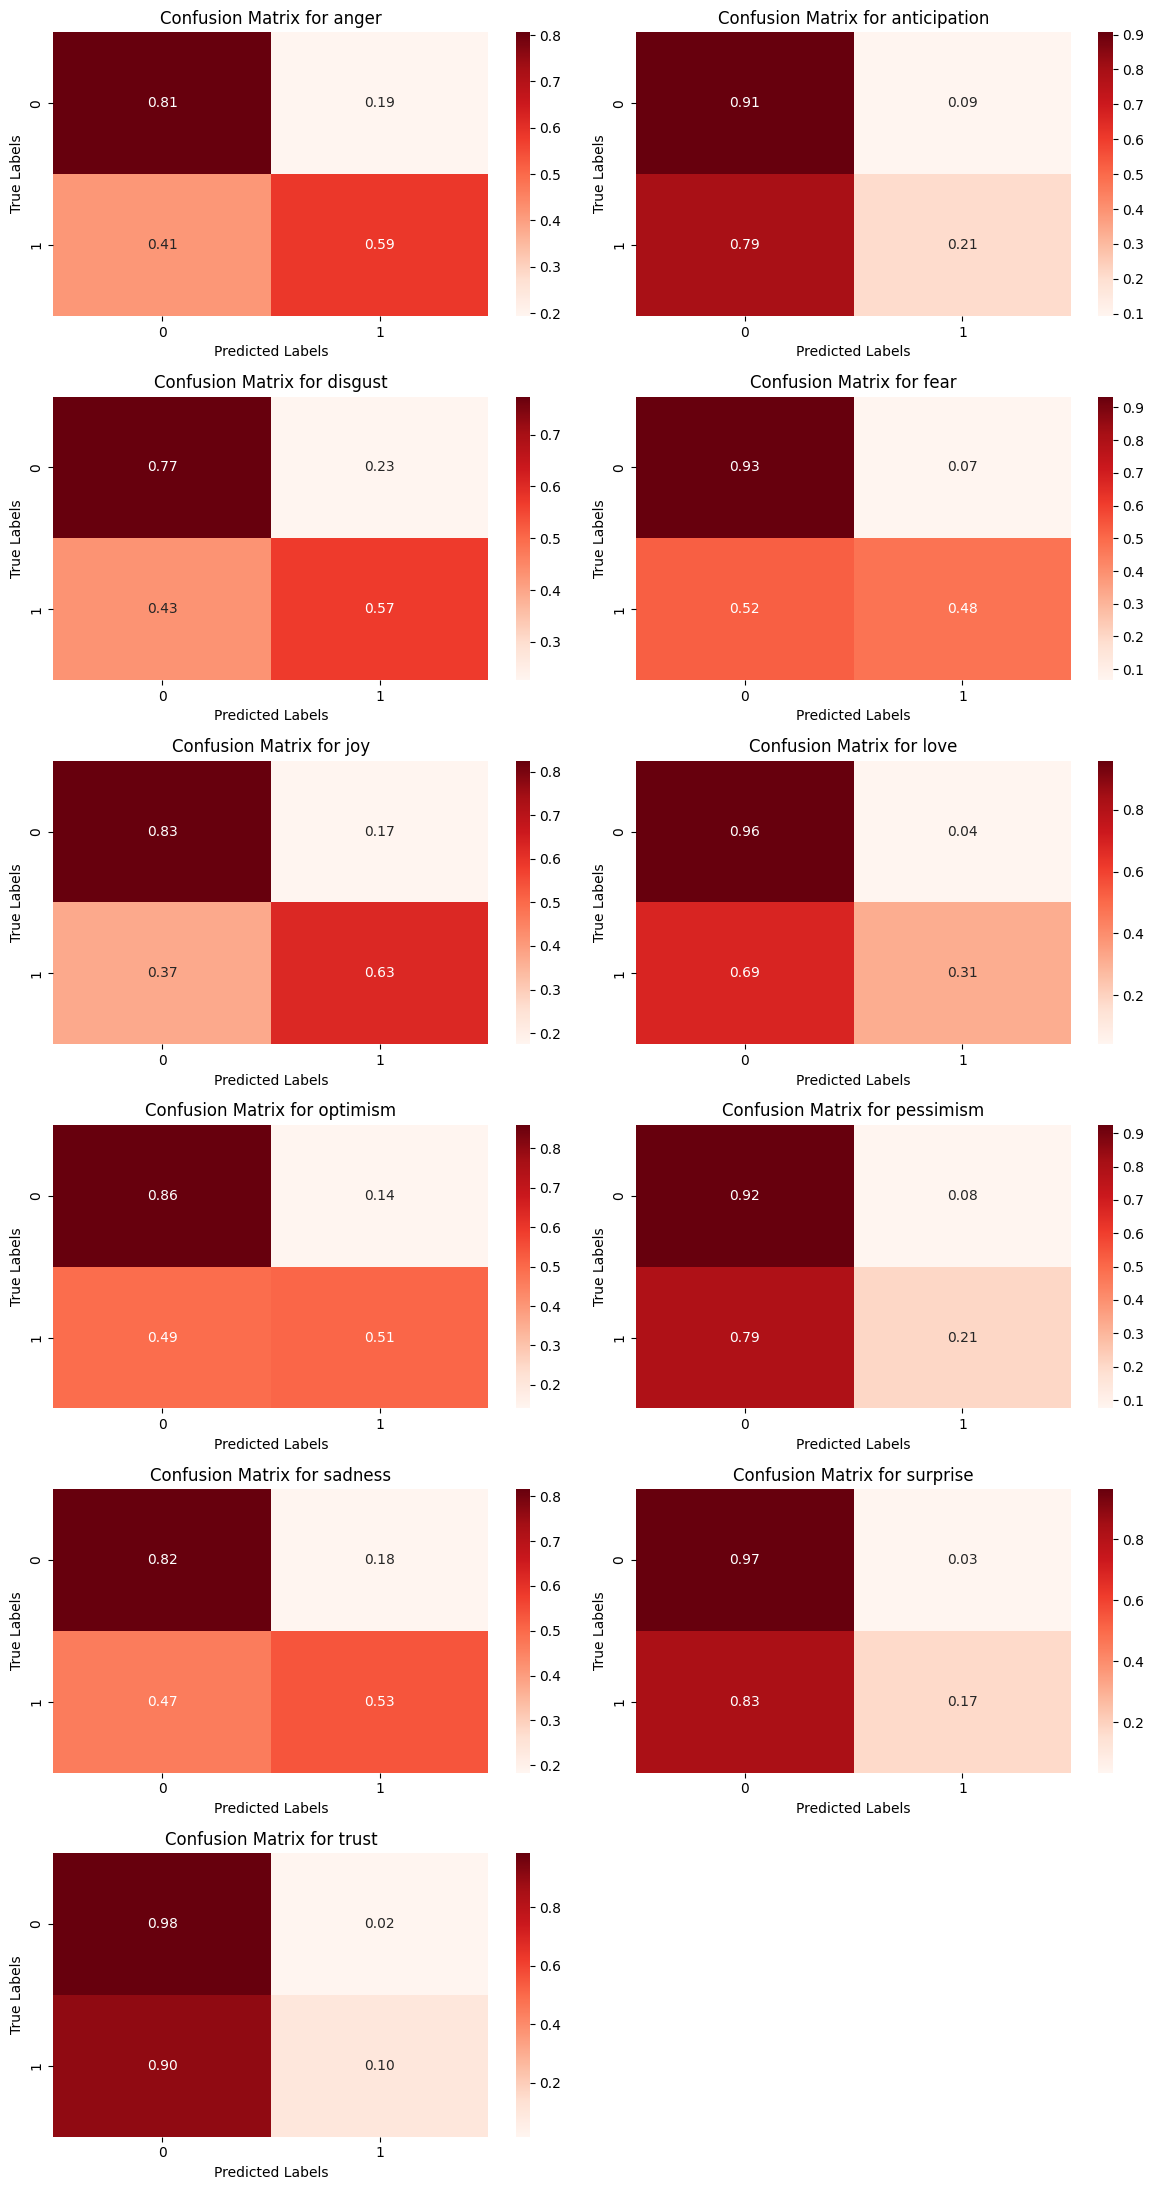

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert valid_output to numpy arrays
valid_labels_np = np.array(valid_output.label_ids)  # Shape: (n_samples, n_classes)
valid_preds_np = np.array(valid_output.predictions)  # Shape: (n_samples, n_classes)

# Convert probabilities to binary predictions
threshold = 0.5
valid_preds_np = (valid_preds_np > threshold).astype(int)  # Shape: (n_samples, n_classes)

def plot_multilabel_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots confusion matrices for each class in multilabel classification.

    Args:
        valid_labels (array-like): True labels of the validation data (shape: [n_samples, n_classes]).
        valid_preds (array-like): Predicted labels of the validation data (shape: [n_samples, n_classes]).
        class_labels (list): List of class names for the labels.
    """
    n_classes = len(class_labels)

    # Create a figure to hold all the subplots
    fig, axes = plt.subplots(nrows=(n_classes + 1) // 2, ncols=2, figsize=(12, n_classes * 2))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(n_classes):
        # Compute the confusion matrix for each class
        cm = confusion_matrix(valid_labels[:, i], valid_preds[:, i], normalize='true')

        # Plot the confusion matrix using Seaborn
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", ax=ax,
                    xticklabels=["0", "1"], yticklabels=["0", "1"])

        ax.set_title(f'Confusion Matrix for {class_labels[i]}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

    # Remove any empty subplots
    for j in range(n_classes, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout
    plt.show()

# Call the function with the converted multilabel data
plot_multilabel_confusion_matrix(valid_labels_np, valid_preds_np, class_labels=list(my_config.id2label.values()))


In [38]:
# Make predictions on the test set
predictions = trainer.predict(testset)

In [39]:
# Extract the predicted logits
pred_logits = predictions.predictions

# Apply sigmoid to the logits to convert them into probabilities
pred_probs = torch.sigmoid(torch.tensor(pred_logits))

# Convert probabilities into binary labels (threshold at 0.5)
pred_labels = (pred_probs > 0.5).int().numpy()  # Convert to numpy array with 0s and 1s

In [40]:
pred_labels

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]], dtype=int32)

In [41]:
# Load the test dataset again from CSV files to include ID column
test_df = pd.read_csv(data_folder / 'test.csv')

In [42]:
test_df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3255,2018-00416,@lomadia heard of Remothered? Indie horror gam...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3256,2018-03717,All this fake outrage. Y'all need to stop 🤣,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3257,2018-03504,Would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [43]:
# Create a DataFrame with predictions
submission_df = pd.DataFrame({
    'ID': test_df['ID'],  # Assuming 'ID' is the identifier column in your test data
    'anger': pred_labels[:, 0],
    'anticipation': pred_labels[:, 1],
    'disgust': pred_labels[:, 2],
    'fear': pred_labels[:, 3],
    'joy': pred_labels[:, 4],
    'love': pred_labels[:, 5],
    'optimism': pred_labels[:, 6],
    'pessimism': pred_labels[:, 7],
    'sadness': pred_labels[:, 8],
    'surprise': pred_labels[:, 9],
    'trust': pred_labels[:, 10]
})

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [44]:
# Load the train and test datasets from CSV files
submissions_df = pd.read_csv('/content/submission.csv')

In [45]:
submission_df.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,1,1,1,0,0,0,0,0,1,0
1,2018-03739,1,0,1,0,0,0,0,0,0,0,0
2,2018-00385,1,0,1,1,0,0,0,0,0,1,0
3,2018-03001,0,0,1,0,0,0,0,0,1,0,0
4,2018-01988,0,0,0,1,0,0,0,0,1,0,0
